### **1) Install dependencies**

In [ ]:
import os
import sys
import torch

# install gradslam
try:
    import gradslam as gs
except ImportError:
    print("Installing gradslam...")
    !pip install 'git+https://github.com/gradslam/gradslam.git' -q
    print('Installed')

# install pytorch3d
if (torch.__version__=='1.6.0+cu101') and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

# get perceptual similarity 
!git clone https://github.com/shubhtuls/PerceptualSimilarity.git

Installing gradslam...
     |████████████████████████████████| 225kB 31.1MB/s 
     |████████████████████████████████| 13.2MB 254kB/s 
     |████████████████████████████████| 4.6MB 49.3MB/s 
     |████████████████████████████████| 36.7MB 67kB/s 
Installed
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0   1475      0 --:--:-- --:--:-- --:--:--  1475
100  404k    0  404k    0     0  1482k      0 --:--:-- --:--:-- --:--:-- 1482k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-qq2yd5ju
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-qq2yd5ju
  Running command git checkout -q 18ce14cd31a2f1c99e16d727e1755156c360453a
     |████████████████████████████████| 276kB 18.0MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.3.0-cp36-cp36m-linux_x86

### **2) Download dataset**

In [ ]:
# download 'lr kt1' of the ICL dataset
if not os.path.isdir('ICL'):
    os.mkdir('ICL')
if not os.path.isdir('ICL/living_room_traj1_frei_png'):
    print('Downloading ICL/living_room_traj1_frei_png dataset...')
    os.mkdir('ICL/living_room_traj1_frei_png')
    !wget http://www.doc.ic.ac.uk/~ahanda/living_room_traj1_frei_png.tar.gz -P ICL/living_room_traj1_frei_png/ -q
    !tar -xzf ICL/living_room_traj1_frei_png/living_room_traj1_frei_png.tar.gz -C ICL/living_room_traj1_frei_png/
    !rm ICL/living_room_traj1_frei_png/living_room_traj1_frei_png.tar.gz
    !wget https://www.doc.ic.ac.uk/~ahanda/VaFRIC/livingRoom1n.gt.sim -P ICL/living_room_traj1_frei_png/ -q
    print('Downloaded.')
icl_path = 'ICL/'

Downloaded.


### **3) Obtain ground-truth reconstruction**


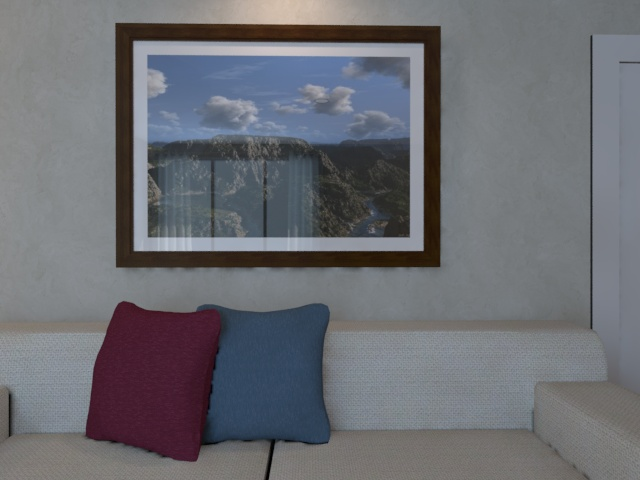
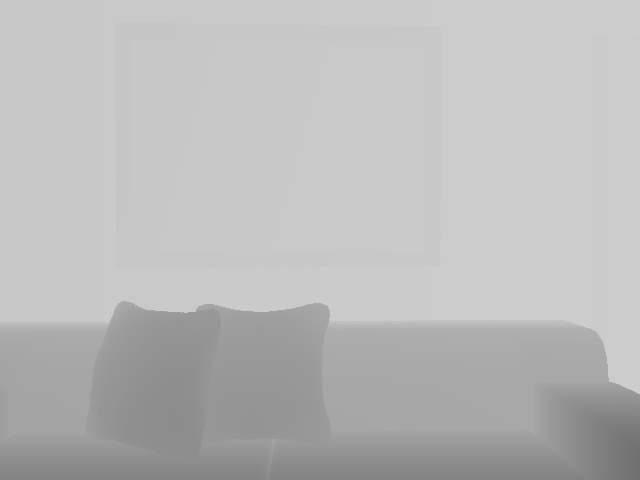
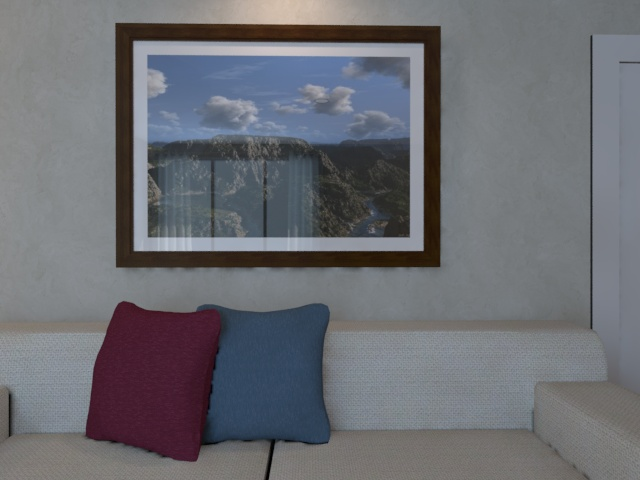
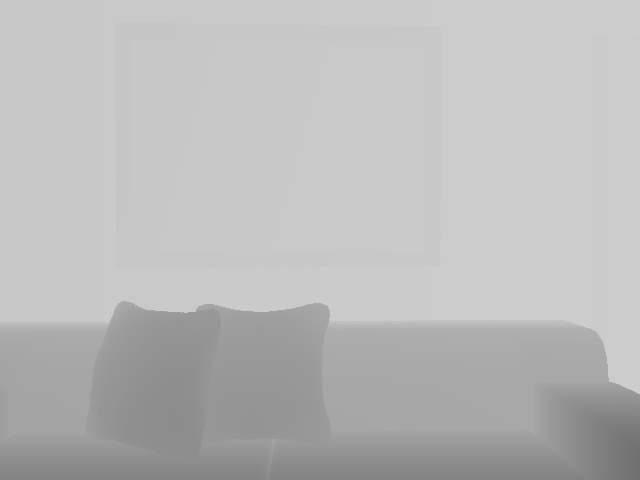
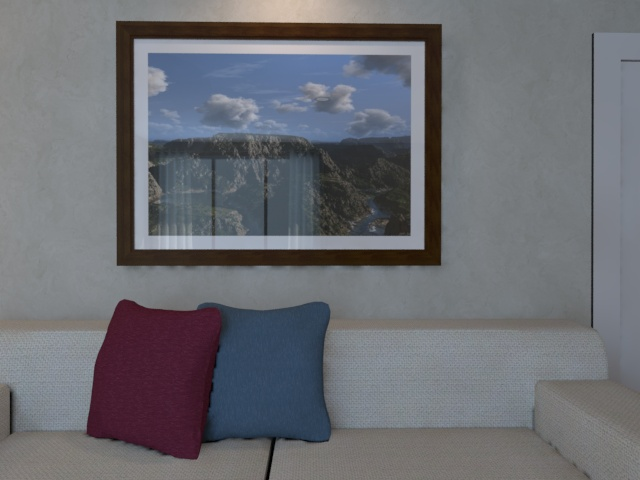
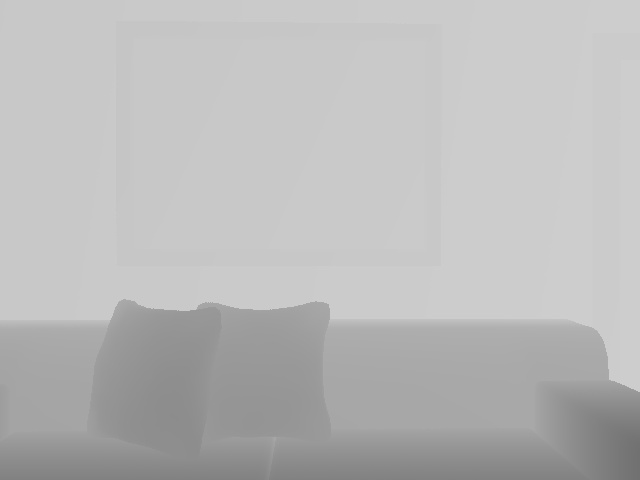
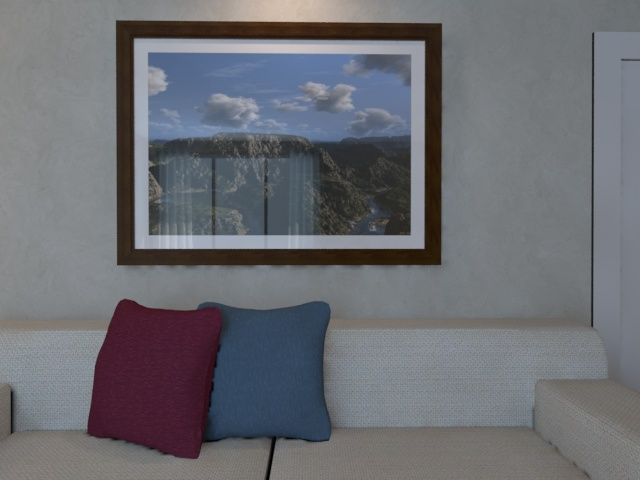
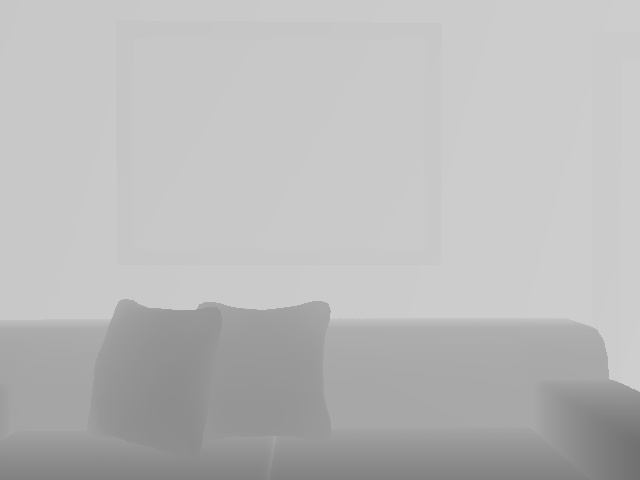
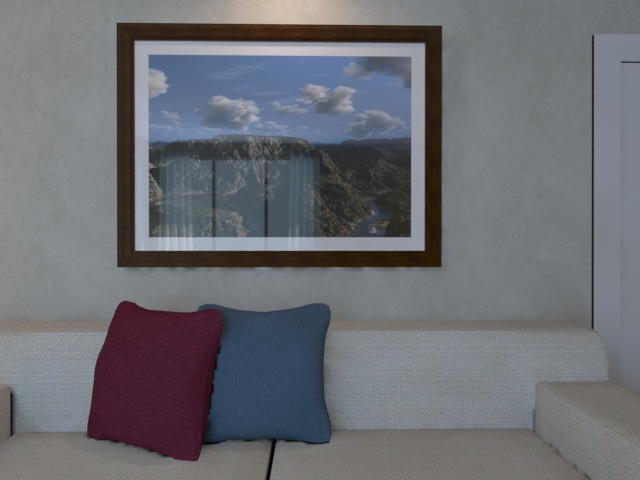
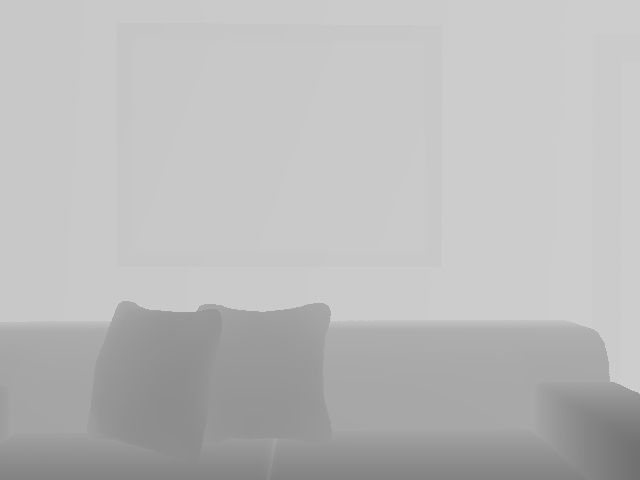

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

from gradslam import Pointclouds, RGBDImages
from gradslam.datasets import ICL
from gradslam.slam import PointFusion
from torch.utils.data import DataLoader

# set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# load first 4 frames of the sequence
dataset = ICL(icl_path, seqlen=4, height=480, width=640)
loader = DataLoader(dataset=dataset, batch_size=1)
colors, depths, intrinsics, poses, *_ = next(iter(loader))

# create an RGBDImages object
rgbdimages = RGBDImages(colors, depths, intrinsics, poses)
rgbdimages.plotly(0).update_layout(autosize=False, height=800, width=600).show()

In [ ]:
# use PointFusion to obtain "ground-truth" 3D reconstruction
slam = PointFusion(device=device)
gt_pointclouds, recovered_poses = slam(rgbdimages)
gt_pointclouds.plotly(0, max_num_points=50000).update_layout(autosize=False, width=600).show()

### **4) Define function for chamfer distance**

In [ ]:
# define chamfer distance from corrupted to ground-truth reconstruction point clouds
from chamferdist import ChamferDistance

def chamfer_dist(pred_pointcloud, tgt_pointcloud):
  chamferDist = ChamferDistance()
  pred_points = pred_pointcloud.points_padded 
  tgt_points = tgt_pointcloud.points_padded
  dist_forward = chamferDist(pred_points, tgt_points)
  return dist_forward.mean()

### **5) Define function for renderering pointclouds**

In [ ]:
# define renderer for point clouds
from pytorch3d.structures import Pointclouds as PointClouds
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRasterizer,
    PointsRenderer,
    NormWeightedCompositor
)

R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)
raster_settings = PointsRasterizationSettings(
    image_size = 512, 
    radius = 0.003,
    points_per_pixel = 10
)
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer = rasterizer,
    compositor = NormWeightedCompositor(background_color=(1, 1, 1))
)

# function to render a pair of point clouds
def render(pred_pointcloud, tgt_pointcloud):
  pred_verts = pred_pointcloud.points_list[0].to(device)
  pred_rgb = (pred_pointcloud.colors_list[0] / 255.0).to(device)
  pred_PointCloud = PointClouds(points=[pred_verts], features=[pred_rgb])
  pred_image = renderer(pred_PointCloud).permute(0,3,1,2).contiguous()

  tgt_verts = tgt_pointcloud.points_list[0].to(device)
  tgt_rgb = (tgt_pointcloud.colors_list[0] / 255.0).to(device)
  tgt_PointCloud = PointClouds(points=[tgt_verts], features=[tgt_rgb])
  tgt_image = renderer(tgt_PointCloud).permute(0,3,1,2).contiguous()

  return pred_image,tgt_image

### **6) Set parameters for experiment**

In [ ]:
# set odometry method for corrupted reconstruction
# possible values are ['gt', 'icp', 'gradicp']
odometry = 'gt' 

# set number of iterations to optimize for 
num_iters = 400

# set learning rate
lr = 0.01

# set logging frequency 
logging_freq = 20

## **7) Part 1**

#### **7.1) Load data and make last frame as a constant**

Corrupted Frame



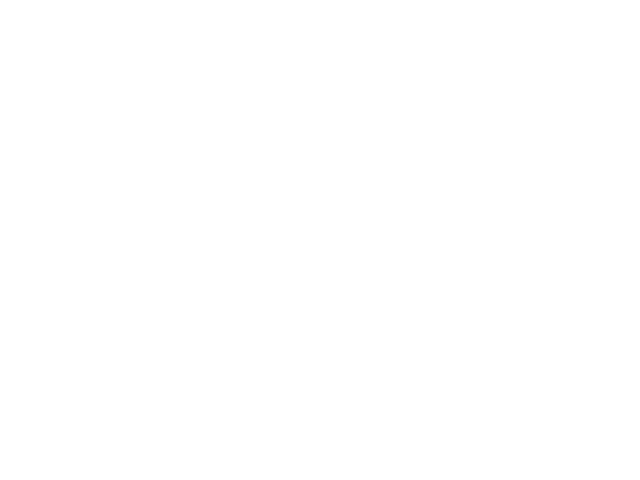
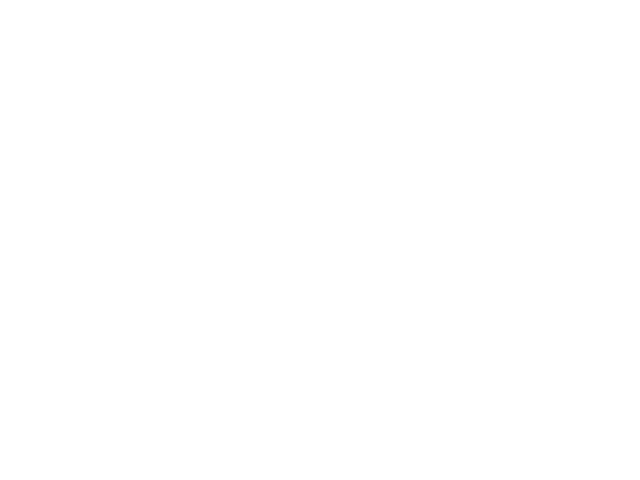
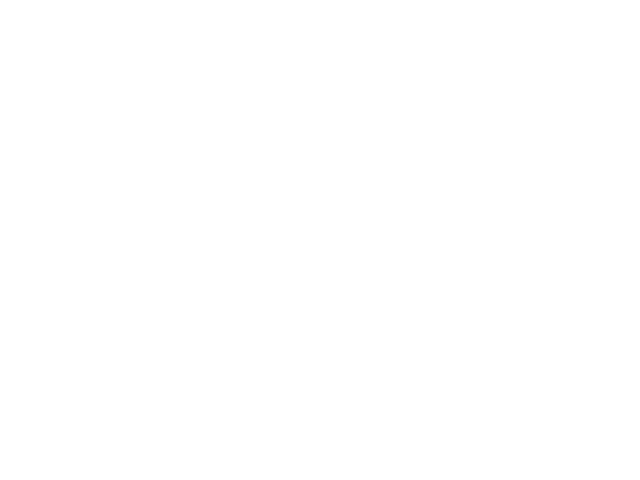
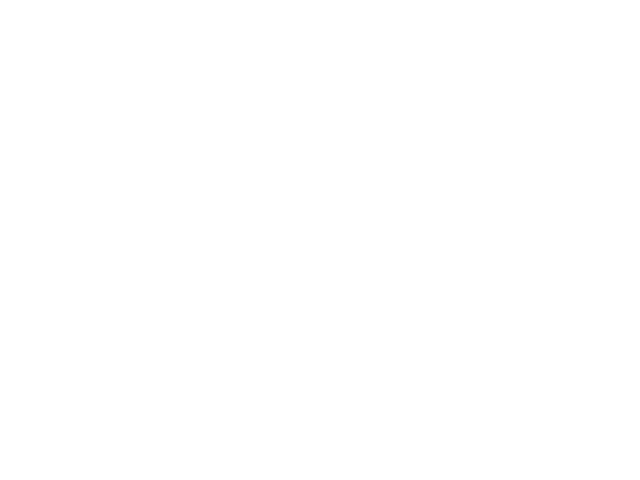

In [ ]:
# load first 4 frames in the sequence one by one separately
dataset = ICL(icl_path, seqlen=1, height=480, width=640)
loader = DataLoader(dataset=dataset, batch_size=1)
it=iter(loader)
c0, d0, i0, p0, *_ = next(it)
c1, d1, i1, p1, *_ = next(it)
c2, d2, i2, p2, *_ = next(it)
c3, d3, i3, p3, *_ = next(it)

# save uncorrupted color and depth for visualization later
temp_c3 = c3.clone().detach()
temp_d3 = d3.clone().detach()
temp_r = RGBDImages(temp_c3, temp_d3, i3, p3)

# replace values in the last color and depth image by a constant and enable gradient flow
c3 = (torch.ones((1,1,480,640,3), dtype=torch.float32) * 255.0).detach().requires_grad_(True)
d3 = (torch.ones((1,1,480,640,1), dtype=torch.float32) * 2.550).detach().requires_grad_(True)

# create RGBDImages objects and visualize
r0 = RGBDImages(c0, d0, i0, p0)
r1 = RGBDImages(c1, d1, i1, p1)
r2 = RGBDImages(c2, d2, i2, p2)
r3 = RGBDImages(c3, d3, i3, p3)

print("Corrupted Frame")
r3.plotly(0).update_layout(autosize=False, height=800, width=600).show()

#### **7.2) Optimize corrupted color and depth images**

In [ ]:
# define optimizer
optimizer = torch.optim.Adam([r3.rgb_image, r3.depth_image],lr=lr)

slam = PointFusion(odom=odometry,device=device)
map = {0:r0, 1:r1, 2:r2, 3:r3 }

for i in range(num_iters):
  optimizer.zero_grad()

  pointclouds_noise = Pointclouds(device=device)
  prev_frame = None
  for s in range(4):
      live_frame = map[s].to(device)
      pointclouds_noise, live_frame.poses = slam.step(pointclouds_noise, live_frame, prev_frame)
      prev_frame = live_frame if slam.odom != 'gt' else None
  
  chamfer_loss = chamfer_dist(pointclouds_noise,gt_pointclouds)
  pred_image, tgt_image = render(pointclouds_noise,gt_pointclouds)
  loss = chamfer_loss + torch.nn.functional.mse_loss(pred_image, tgt_image)
  
  if i%(logging_freq) == 0 :
    print("Iter:" , i, "Loss:", loss.item())
  
  loss.backward()
  optimizer.step()

/usr/local/lib/python3.6/dist-packages/gradslam/slam/fusionutils.py:408: RuntimeWarning:

No similar map points were found (despite total 350311 active points across the batch)



Iter: 0 Loss: 115391.8359375
Iter: 20 Loss: 56119.48828125
Iter: 40 Loss: 24758.134765625
Iter: 60 Loss: 11514.01953125
Iter: 80 Loss: 6221.3046875
Iter: 100 Loss: 4045.86865234375
Iter: 120 Loss: 3059.874267578125
Iter: 140 Loss: 2661.92041015625
Iter: 160 Loss: 2510.094482421875
Iter: 180 Loss: 2442.698486328125
Iter: 200 Loss: 2402.027587890625
Iter: 220 Loss: 2371.611083984375
Iter: 240 Loss: 2347.4423828125
Iter: 260 Loss: 2328.968505859375
Iter: 280 Loss: 2315.066650390625
Iter: 300 Loss: 2304.54736328125
Iter: 320 Loss: 2296.565673828125
Iter: 340 Loss: 2290.510498046875
Iter: 360 Loss: 2285.72314453125
Iter: 380 Loss: 2282.278564453125


#### **7.3) Visualize optimized image**

Original Uncorrupted Frame



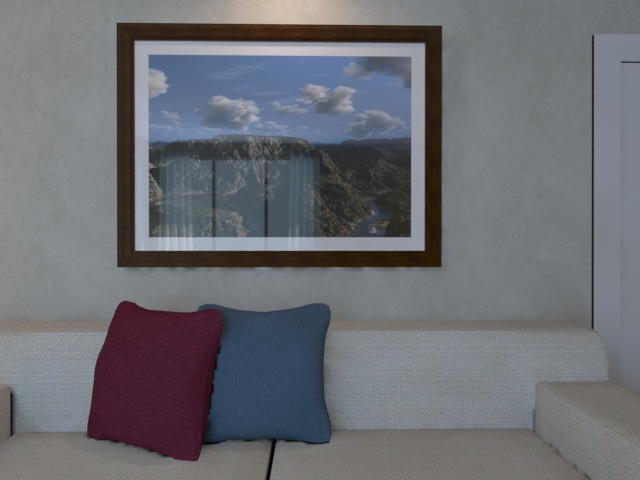
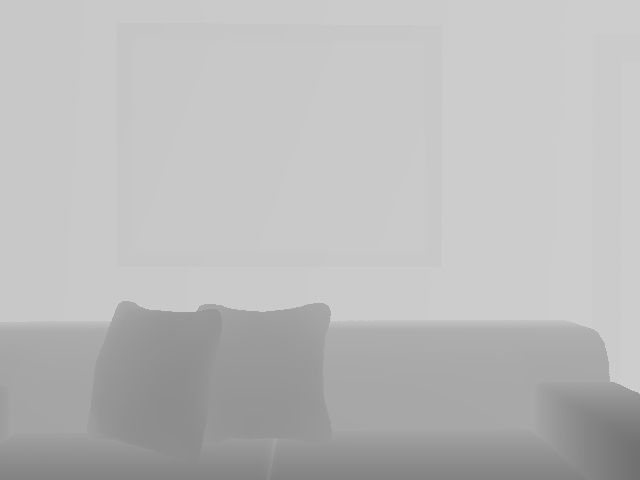
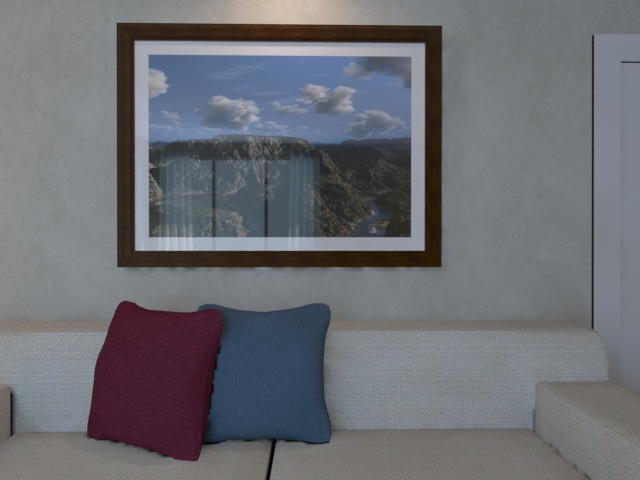
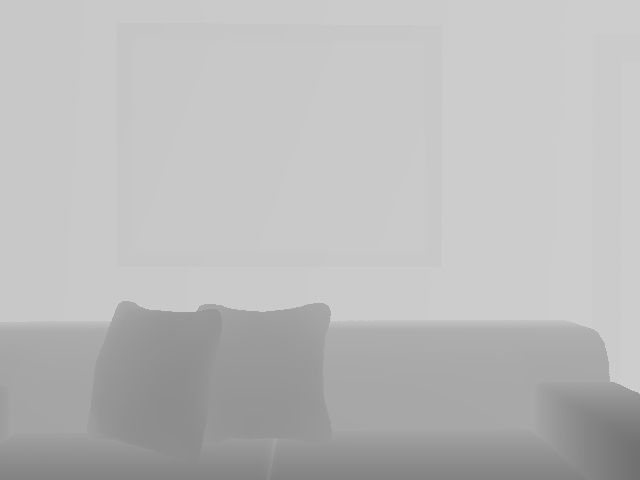

Optimized Corrupted Frame



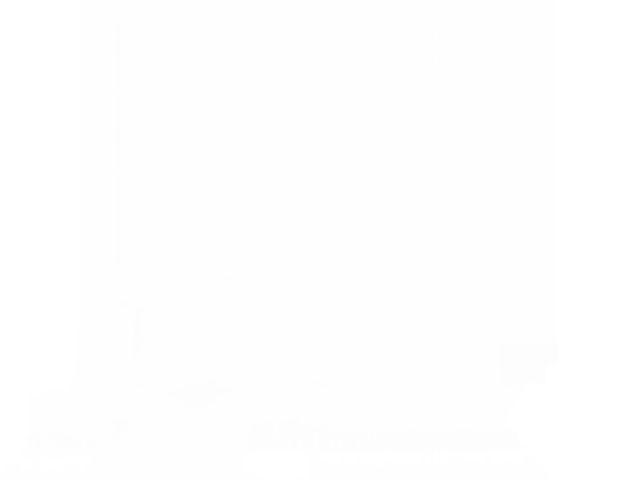
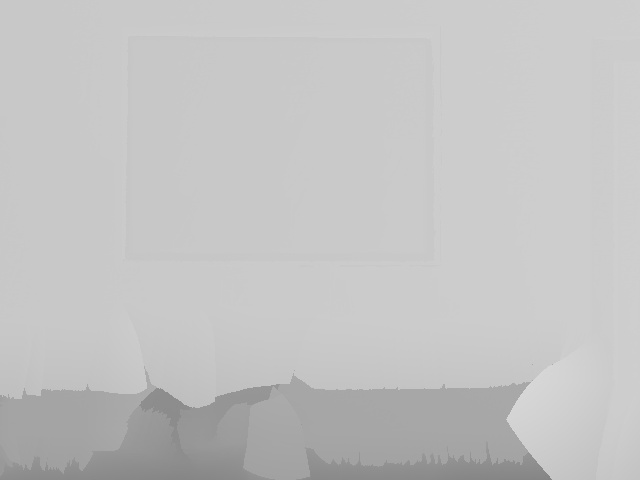
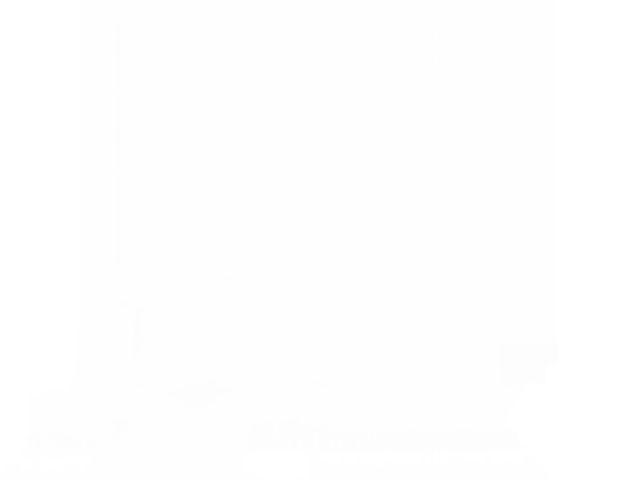
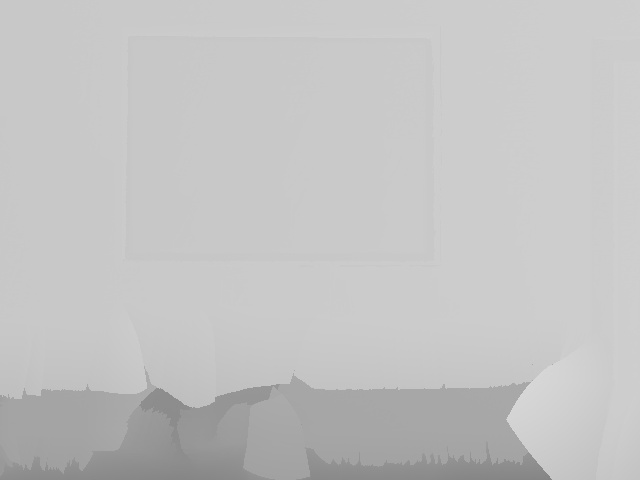

In [ ]:
# visualize optimized RGBDImage
print("Original Uncorrupted Frame")
temp_r.plotly(0).update_layout(autosize=False, height=800, width=600).show()

print("Optimized Corrupted Frame")
r3.plotly(0).update_layout(autosize=False, height=800, width=600).show()

## **8) Part 2**

#### **8.1) Load data and add noise to last frame**

Corrupted Frame



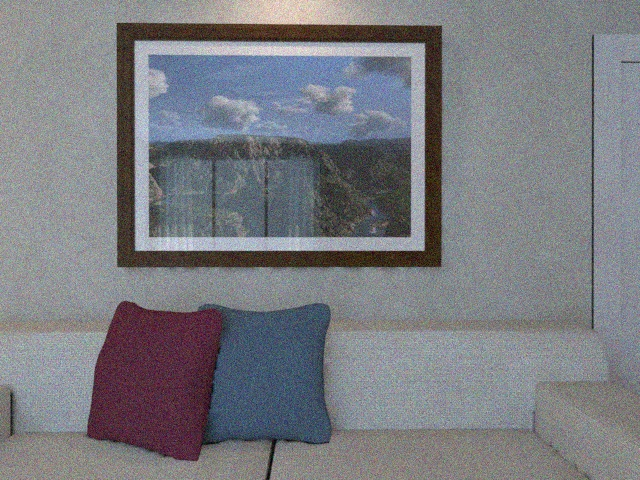
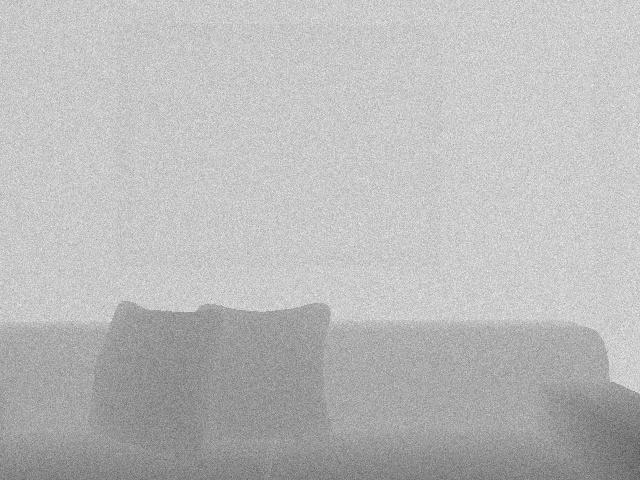
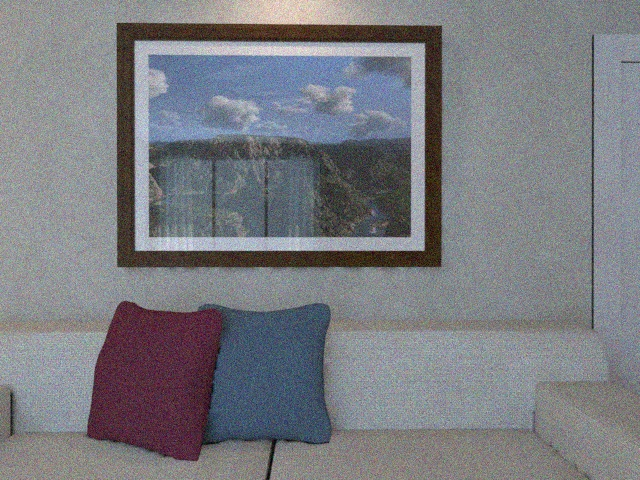
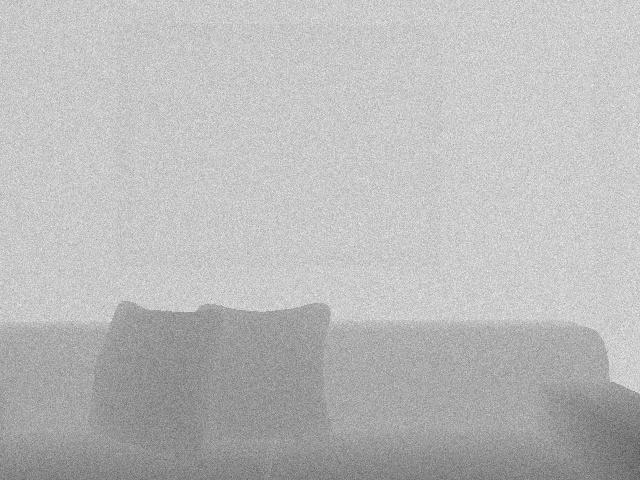

In [ ]:
# load first 4 frames in the sequence one by one separately
dataset = ICL(icl_path, seqlen=1, height=480, width=640)
loader = DataLoader(dataset=dataset, batch_size=1)
it=iter(loader)
c0, d0, i0, p0, *_ = next(it)
c1, d1, i1, p1, *_ = next(it)
c2, d2, i2, p2, *_ = next(it)
c3, d3, i3, p3, *_ = next(it)

# save uncorrupted color and depth for visualization later
temp_c3 = c3.clone().detach()
temp_d3 = d3.clone().detach()
temp_r = RGBDImages(temp_c3, temp_d3, i3, p3)

# add noise to the last color and depth image and enable gradient flow
noise_rgb = 15 + 15 * torch.randn((1,1,480,640,3))
noise_depth = 0.1 * torch.randn((1,1,480,640,1))
c3 = torch.add(c3,noise_rgb).detach().requires_grad_(True)
d3 = torch.add(d3,noise_depth).detach().requires_grad_(True)

# create RGBDImages objects and visualize
r0 = RGBDImages(c0, d0, i0, p0)
r1 = RGBDImages(c1, d1, i1, p1)
r2 = RGBDImages(c2, d2, i2, p2)
r3 = RGBDImages(c3, d3, i3, p3)

print("Corrupted Frame")
r3.plotly(0).update_layout(autosize=False, height=800, width=600).show()

#### **8.2) Optimize corrupted color and depth images**

In [ ]:
# define optimizer
optimizer = torch.optim.Adam([r3.rgb_image, r3.depth_image],lr=lr)

slam = PointFusion(odom=odometry,device=device)
map = {0:r0, 1:r1, 2:r2, 3:r3 }

for i in range(num_iters):
  optimizer.zero_grad()

  pointclouds_noise = Pointclouds(device=device)
  prev_frame = None
  for s in range(4):
      live_frame = map[s].to(device)
      pointclouds_noise, live_frame.poses = slam.step(pointclouds_noise, live_frame, prev_frame)
      prev_frame = live_frame if slam.odom != 'gt' else None
  
  chamfer_loss = chamfer_dist(pointclouds_noise,gt_pointclouds)
  pred_image, tgt_image = render(pointclouds_noise,gt_pointclouds)
  loss = chamfer_loss + torch.nn.functional.mse_loss(pred_image, tgt_image)
  
  if i%(logging_freq) == 0 :
    print("Iter:" , i, "Loss:", loss.item())
  
  loss.backward()
  optimizer.step()

Iter: 0 Loss: 2469.437744140625
Iter: 20 Loss: 127.87666320800781
Iter: 40 Loss: 48.759742736816406
Iter: 60 Loss: 35.12192153930664
Iter: 80 Loss: 33.07242202758789
Iter: 100 Loss: 32.678436279296875
Iter: 120 Loss: 32.636905670166016
Iter: 140 Loss: 32.644073486328125
Iter: 160 Loss: 32.65321350097656
Iter: 180 Loss: 32.64963912963867
Iter: 200 Loss: 32.660247802734375
Iter: 220 Loss: 32.6679801940918
Iter: 240 Loss: 32.66936492919922
Iter: 260 Loss: 32.67382049560547
Iter: 280 Loss: 32.679134368896484
Iter: 300 Loss: 32.69452667236328
Iter: 320 Loss: 32.69047927856445
Iter: 340 Loss: 32.696720123291016
Iter: 360 Loss: 32.703617095947266
Iter: 380 Loss: 32.7039794921875


#### **8.3) Visualize optimized image**

Original Uncorrupted Frame



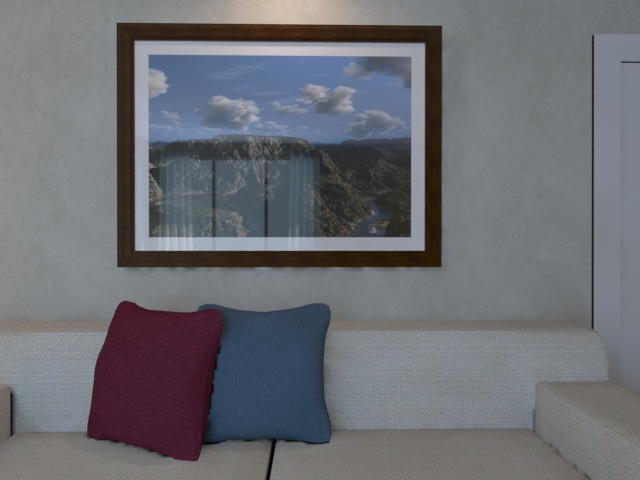
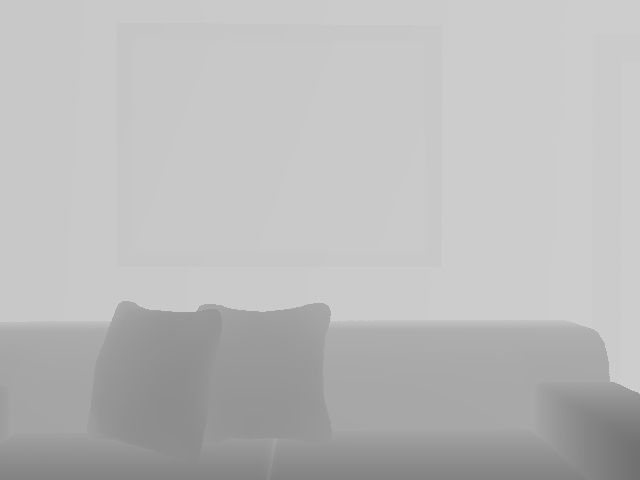
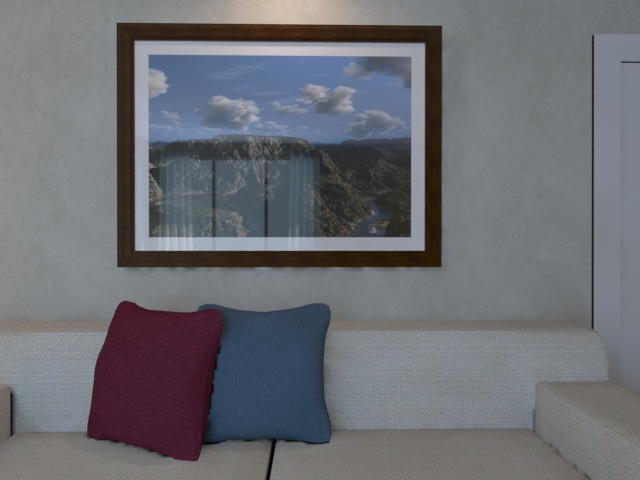
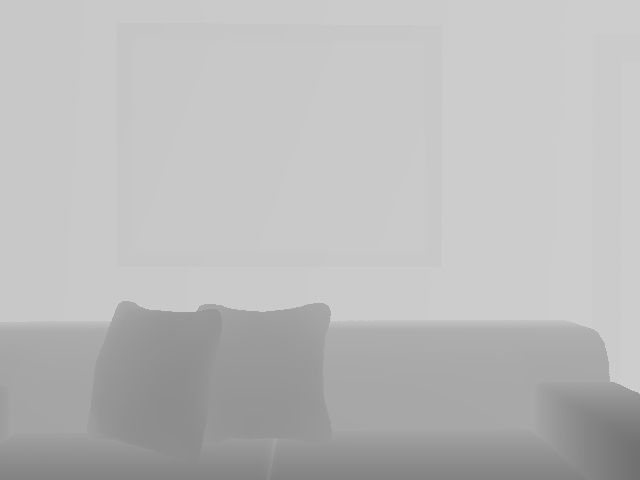

Optimized Corrupted Frame



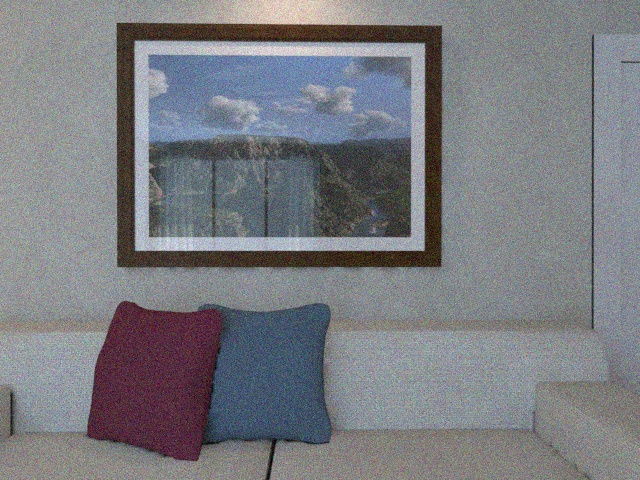
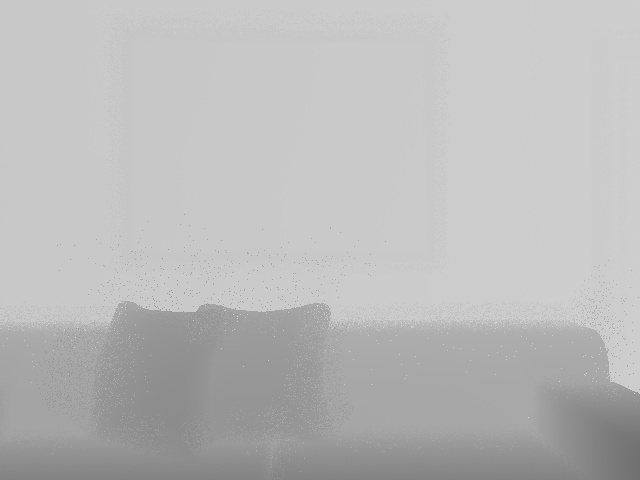
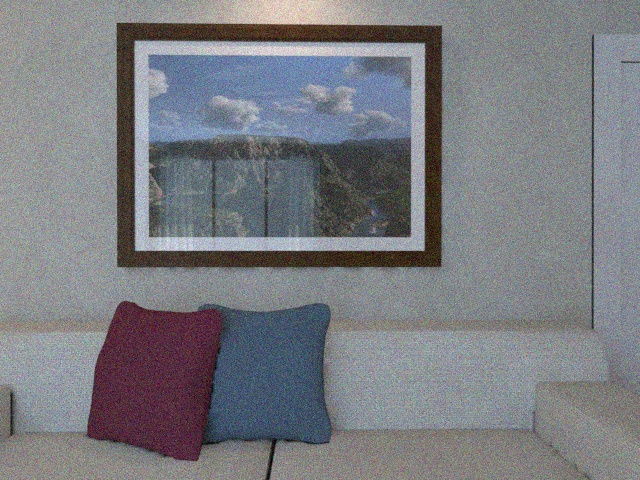
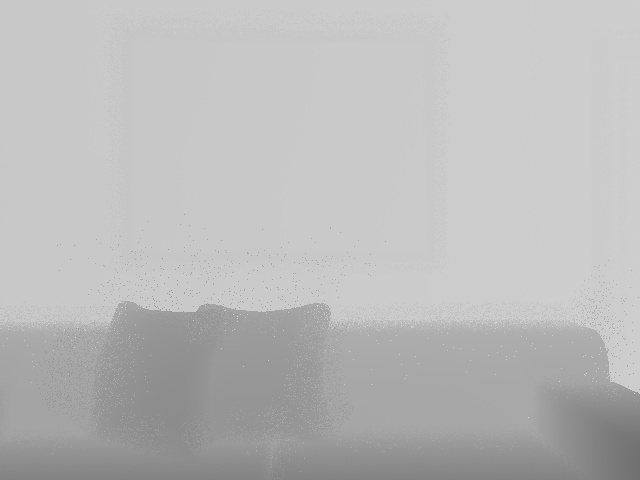

In [ ]:
# visualize optimized RGBDImage
print("Original Uncorrupted Frame")
temp_r.plotly(0).update_layout(autosize=False, height=800, width=600).show()

print("Optimized Corrupted Frame")
r3.plotly(0).update_layout(autosize=False, height=800, width=600).show()

## **9) Using Perceptual Similarity for better color recovery**

In [ ]:
# define perceptual loss
from PerceptualSimilarity.models import dist_model

class PerceptualLoss(object):
    def __init__(self, model='net', net='alex', use_gpu=True):
        print('Setting up Perceptual loss..')
        self.model = dist_model.DistModel()
        self.model.initialize(model=model, net=net, use_gpu=True)
        print('Done')

    def __call__(self, pred, target, normalize=True):
        """
        pred, target are tensors of shape B x 3 x H x W
        Assumes the inputs are in range [0, 1].
        If normalize is on, scales images between [-1, 1]
        """
        if normalize:
            target = 2 * target - 1
            pred = 2 * pred - 1

        dist = self.model.forward_pair(target, pred)
        return dist.mean()

Corrupted Frame



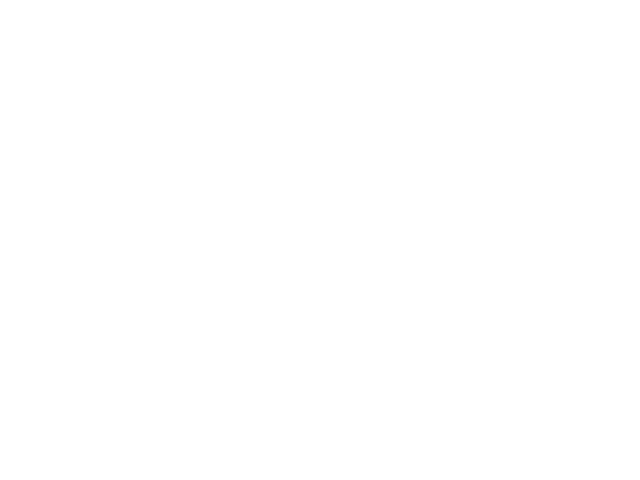
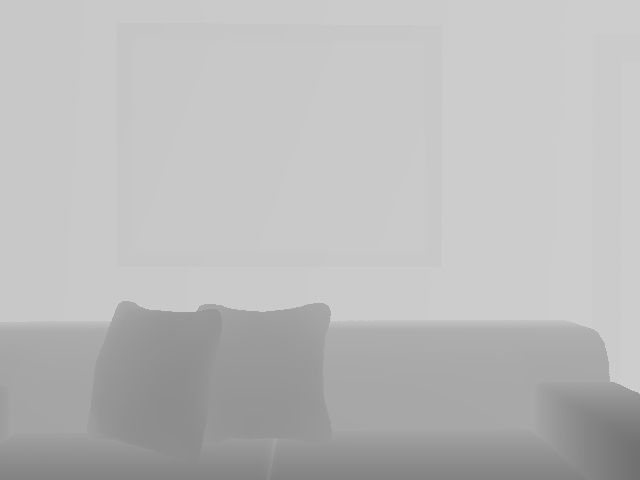
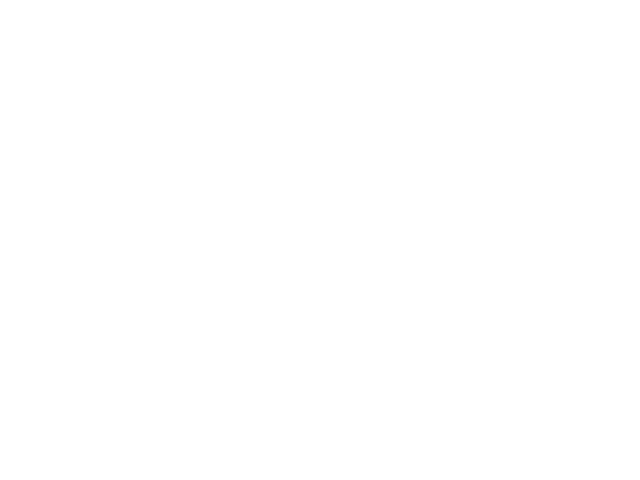
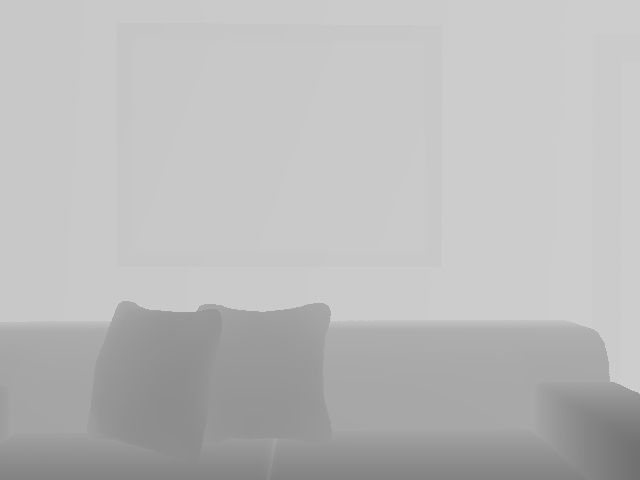

In [ ]:
# load first 4 frames in the sequence one by one separately
dataset = ICL(icl_path, seqlen=1, height=480, width=640)
loader = DataLoader(dataset=dataset, batch_size=1)
it=iter(loader)
c0, d0, i0, p0, *_ = next(it)
c1, d1, i1, p1, *_ = next(it)
c2, d2, i2, p2, *_ = next(it)
c3, d3, i3, p3, *_ = next(it)

# save uncorrupted color for visualization later
temp_c3 = c3.clone().detach()
temp_r = RGBDImages(temp_c3, d3, i3, p3)

# replace values in the last color image by a constant and enable gradient flow
c3 = (torch.ones((1,1,480,640,3), dtype=torch.float32) * 255.0).detach().requires_grad_(True)

# create RGBDImages objects and visualize
r0 = RGBDImages(c0, d0, i0, p0)
r1 = RGBDImages(c1, d1, i1, p1)
r2 = RGBDImages(c2, d2, i2, p2)
r3 = RGBDImages(c3, d3, i3, p3)

print("Corrupted Frame")
r3.plotly(0).update_layout(autosize=False, height=800, width=600).show()

In [ ]:
color_loss = PerceptualLoss()

optimizer = torch.optim.Adam([r3.rgb_image],lr=0.01)
slam = PointFusion(odom='gt',device=device)
map = {0:r0, 1:r1, 2:r2, 3:r3 }

for i in range(2000):
  optimizer.zero_grad()

  pointclouds_noise = Pointclouds(device=device)
  prev_frame = None
  for s in range(4):
      live_frame = map[s].to(device)
      pointclouds_noise, live_frame.poses = slam.step(pointclouds_noise, live_frame, prev_frame)
      prev_frame = live_frame if slam.odom != 'gt' else None
  
  pred_image, tgt_image = render(pointclouds_noise,gt_pointclouds)
  loss = (1e3) * color_loss(pred_image, tgt_image)
  
  if i%(100) == 0 :
    print("Iter:" , i, "Loss:", loss.item())
  
  loss.backward()
  optimizer.step()

Setting up Perceptual loss..


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Done
Iter: 0 Loss: 1137.799072265625
Iter: 100 Loss: 1030.7728271484375
Iter: 200 Loss: 952.3514404296875
Iter: 300 Loss: 891.3247680664062
Iter: 400 Loss: 842.1543579101562
Iter: 500 Loss: 800.4915161132812
Iter: 600 Loss: 764.0159912109375
Iter: 700 Loss: 732.2530517578125
Iter: 800 Loss: 704.2941284179688
Iter: 900 Loss: 679.4624633789062
Iter: 1000 Loss: 657.3064575195312
Iter: 1100 Loss: 637.242431640625
Iter: 1200 Loss: 618.4888916015625
Iter: 1300 Loss: 600.897705078125
Iter: 1400 Loss: 584.1376342773438
Iter: 1500 Loss: 568.6435546875
Iter: 1600 Loss: 554.3787841796875
Iter: 1700 Loss: 540.9629516601562
Iter: 1800 Loss: 528.4379272460938
Iter: 1900 Loss: 516.6776123046875


Original Uncorrupted Frame



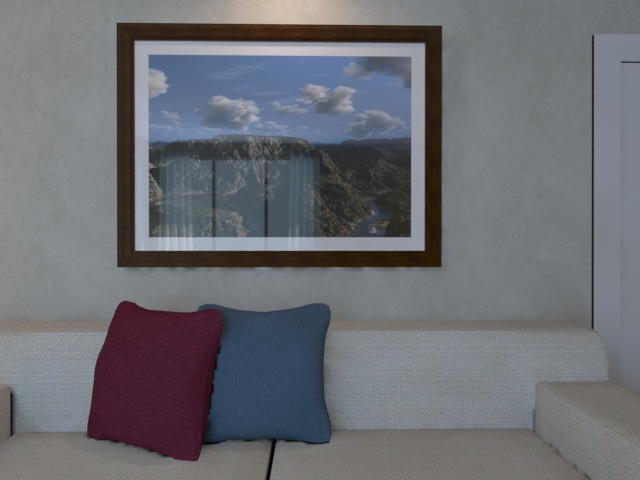
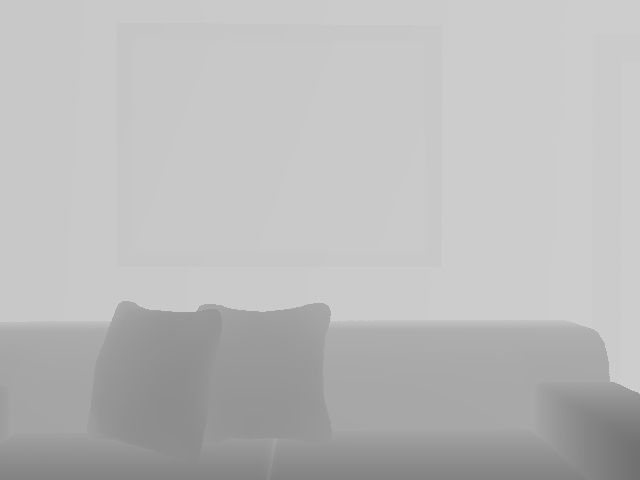
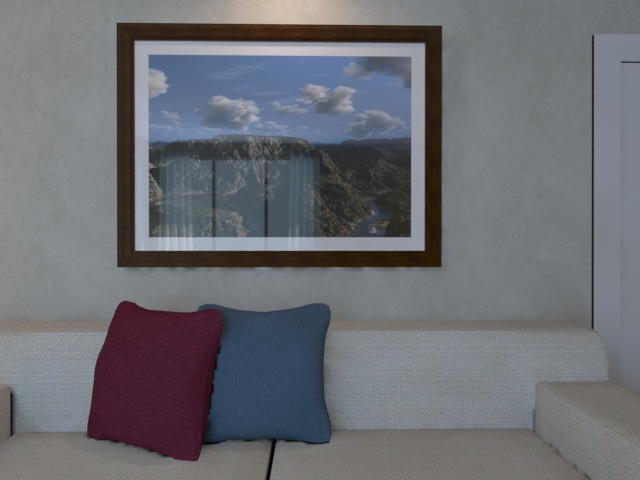
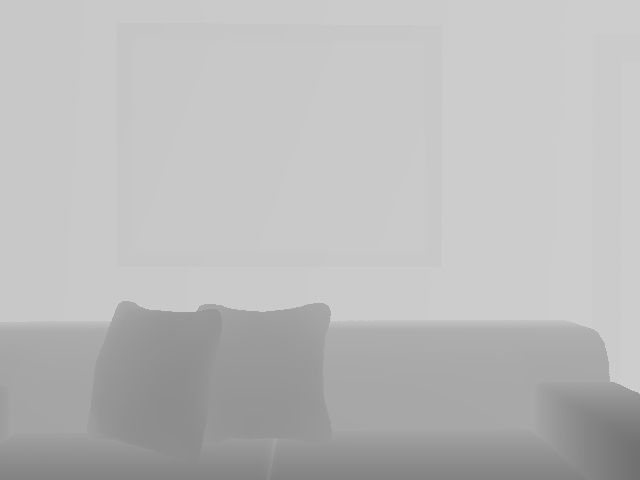

Optimized Corrupted Frame



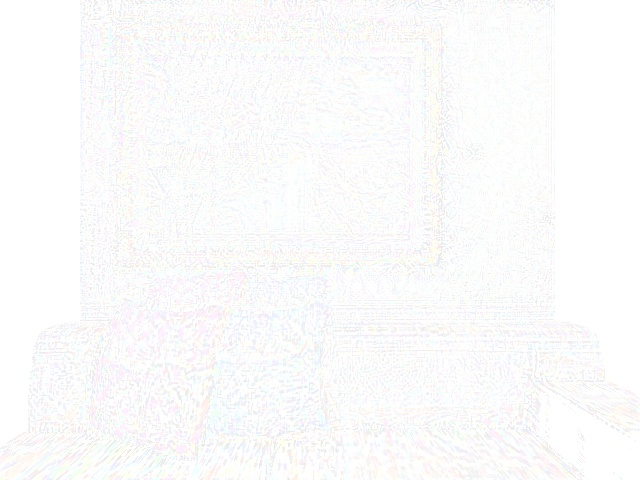
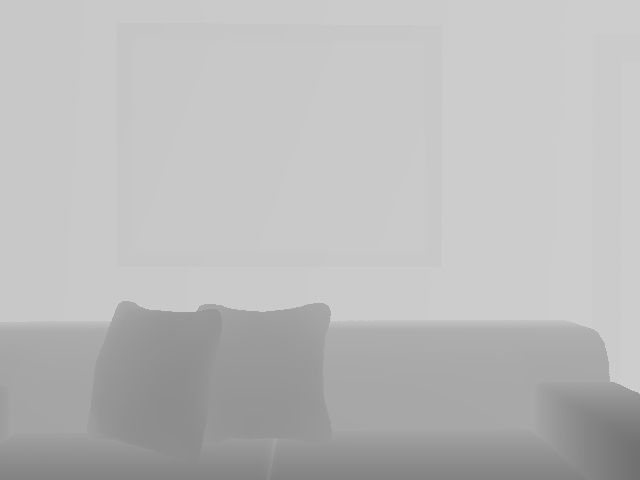
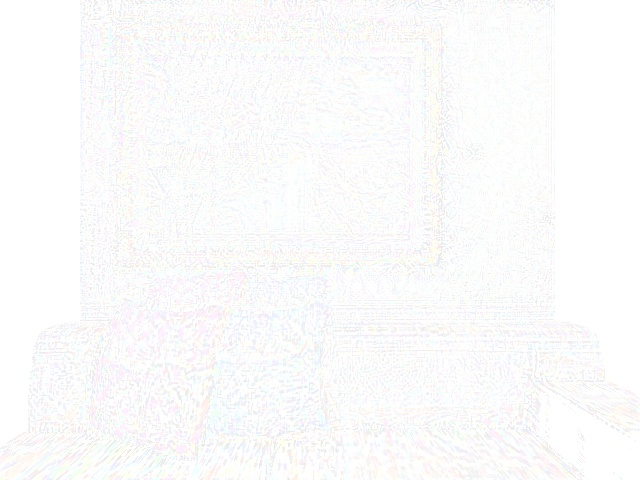
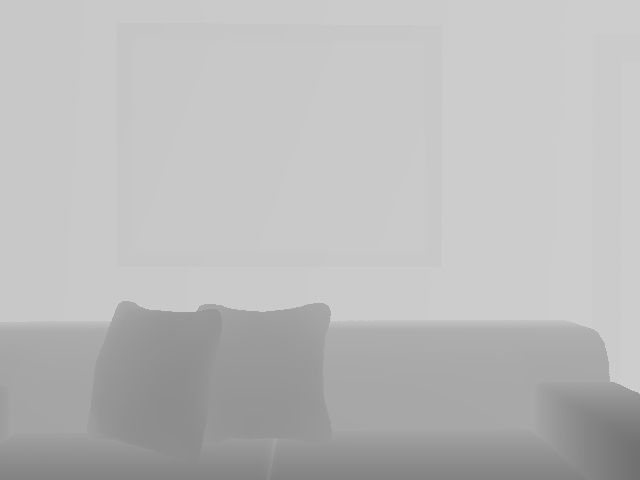

In [ ]:
# visualize optimized RGBDImage
print("Original Uncorrupted Frame")
temp_r.plotly(0).update_layout(autosize=False, height=800, width=600).show()

print("Optimized Corrupted Frame")
r3.plotly(0).update_layout(autosize=False, height=800, width=600).show()